# Librerías

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from pylab import rcParams
%matplotlib inline

# Preparación de datos

Limpieza de datos y preparación para comenzar a crear los arrays de entrenamiento y testeo.

In [36]:
# Se importa el set de datos
dataset_train = pd.read_csv('C:\\Users\\axelm\\Documents\\python\\CienciadeDatosMultivariado\\PruebasRNN\\PM10.csv')

# Se rellenan los valores NaN de la base
dataset_train.fillna(method='ffill', inplace = True)

# Se elimina la columna "Unnamed: 0", dado que no es útil para el modelo
dataset_train.drop(columns = "Unnamed: 0", inplace = True)

# Se seleccionan los datos numéricos que utilizará la red neuronal (se ignora la columna de fecha únicamente)
cols = list(dataset_train)[1:15]

# Se crea la lista de fechas y se les aplica el formato debido
datelist_train = list(dataset_train['date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

# Imprimir la longitud del set de entrenamiento, las semanas totales con las que se cuenta y las columnas que utilizará la red neuronal para entrenarse
print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))
dataset_train

Training set shape == (191, 15)
All timestamps == 191
Featured selected: ['PM10', 'O3', 'NO2', 'CO', 'PM2.5', 'NO', 'NOx', 'SO2', 'PRS', 'RH', 'TOUT', 'SR', 'WSR', 'WDR']


,date,PM10,O3,NO2,CO,PM2.5,NO,NOx,SO2,PRS,RH,TOUT,SR,WSR,WDR
0,2018-01-07,71.684524,12.821429,24.913095,0.920000,28.482143,46.656548,71.072024,5.600000,720.870238,74.547619,8.527440,0.093381,6.745238,114.142857
1,2018-01-14,95.976190,20.017857,22.101786,0.920000,25.154762,25.528571,46.919048,5.600000,716.941071,46.976190,15.755179,0.139560,6.807738,121.077381
2,2018-01-21,77.642857,15.922619,25.070238,0.920000,32.952381,47.320238,72.301786,5.600000,719.257143,75.000000,9.894107,0.093690,6.422619,110.386905
3,2018-01-28,68.595238,13.273810,21.125000,0.920000,29.452381,33.954167,54.704762,5.600000,718.454167,65.589286,14.391607,0.075345,6.776190,95.250000
4,2018-02-04,80.833333,19.732143,24.613690,1.380833,26.958333,21.108929,45.094048,5.600000,717.460119,46.964286,17.425119,0.097089,6.919643,145.029762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,2021-08-01,62.107143,24.779762,10.045833,1.410238,20.809524,8.009524,16.058333,0.744681,713.827976,57.696429,28.157500,0.187250,8.717262,78.190476
187,2021-08-08,61.744048,22.726190,10.276190,1.498810,21.833333,9.544643,17.829167,0.744681,713.321429,63.053571,27.475476,0.143619,8.252976,72.696429
188,2021-08-15,54.142857,25.613095,7.702381,1.351369,17.113095,5.309524,11.002381,0.744681,713.827976,55.690476,28.844226,0.193714,9.527381,82.678571
189,2021-08-22,52.428571,23.440476,7.513690,1.403274,16.291667,5.675000,11.177976,0.744681,711.487500,57.422619,29.110714,0.190452,10.239881,80.416667


In [37]:
# El set de datos de entrenamiento se redefine, utilizando únicamente las variables que tomará el modelo y se convierten en tipo float
dataset_train = dataset_train[cols].astype(float)

# El set de entrenamiento se crea con los valores del data frame correspondiente (se convierte en array)
training_set = dataset_train.values

# Se imprime el tamaño del set de entrenamiento
print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (191, 14).


array([[7.16845238e+01, 1.28214286e+01, 2.49130952e+01, ...,
        9.33809524e-02, 6.74523810e+00, 1.14142857e+02],
       [9.59761905e+01, 2.00178571e+01, 2.21017857e+01, ...,
        1.39559524e-01, 6.80773810e+00, 1.21077381e+02],
       [7.76428571e+01, 1.59226190e+01, 2.50702381e+01, ...,
        9.36904762e-02, 6.42261905e+00, 1.10386905e+02],
       ...,
       [5.41428571e+01, 2.56130952e+01, 7.70238095e+00, ...,
        1.93714286e-01, 9.52738095e+00, 8.26785714e+01],
       [5.24285714e+01, 2.34404762e+01, 7.51369048e+00, ...,
        1.90452381e-01, 1.02398810e+01, 8.04166667e+01],
       [5.88611111e+01, 2.09583333e+01, 8.09444444e+00, ...,
        1.94550725e-01, 1.01236111e+01, 7.94027778e+01]])

# Red neuronal

Preparación de datos, creación de la red y resultados

In [38]:
# Se utiliza el StandardScaler para escalar los datos y transformar el set de entrenamiento para la lectura de la red neuronal
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

# Se modifica también aquello que se utilizará para predecir
sc_predict = StandardScaler()
train_set_scaled = sc_predict.fit_transform(training_set[:, 0:1])

In [39]:
# Se crean los datos de entrenamiento
X_train = []
y_train = []

# Número de semanas que se van a predecir
n_future = 2

# Número de semanas que se utilizarán para predecir
n_past = 10

for i in range(n_past, len(training_set_scaled) - n_future + 1):
    # Se toman las 10 semanas anteriores a la que se desea predecir, junto con las 14 variables que se utilizarán
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    # Se toma la semana que se desea predecir, así como la variable predictora
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

# Se convierten las listas en arrays para que la red neuronal sea capaz de leerlos
X_train, y_train = np.array(X_train), np.array(y_train)

# Se imprimen los tamaños de cada array
print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (180, 10, 14).
y_train shape == (180, 1).


In [40]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Capa de inputs, recibe un input de (10 semanas, 14 variables)
model.add(LSTM(units=25, return_sequences=True, input_shape=(n_past, dataset_train.shape[1])))

# Capas ocultas, de 50 nodos cada una
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.25))

# Capa de resultados, un solo output
model.add(Dense(units=1, activation='linear'))

In [41]:
%%time
# Compilando la red neuronal
model.compile(optimizer = Adam(learning_rate=0.001), loss='mean_squared_error')

history = model.fit(X_train, y_train, shuffle = True, epochs = 50, validation_data = (X_train, y_train), verbose = 2, batch_size = 32)

Epoch 1/50
6/6 - 9s - loss: 0.9949 - val_loss: 0.9300 - 9s/epoch - 1s/step
Epoch 2/50
6/6 - 0s - loss: 0.8909 - val_loss: 0.8125 - 188ms/epoch - 31ms/step
Epoch 3/50
6/6 - 0s - loss: 0.7669 - val_loss: 0.6847 - 193ms/epoch - 32ms/step
Epoch 4/50
6/6 - 0s - loss: 0.6916 - val_loss: 0.6463 - 173ms/epoch - 29ms/step
Epoch 5/50
6/6 - 0s - loss: 0.6480 - val_loss: 0.6017 - 174ms/epoch - 29ms/step
Epoch 6/50
6/6 - 0s - loss: 0.6081 - val_loss: 0.5780 - 177ms/epoch - 30ms/step
Epoch 7/50
6/6 - 0s - loss: 0.5743 - val_loss: 0.5488 - 174ms/epoch - 29ms/step
Epoch 8/50
6/6 - 0s - loss: 0.5403 - val_loss: 0.5351 - 177ms/epoch - 29ms/step
Epoch 9/50
6/6 - 0s - loss: 0.5459 - val_loss: 0.5171 - 202ms/epoch - 34ms/step
Epoch 10/50
6/6 - 0s - loss: 0.5132 - val_loss: 0.5029 - 188ms/epoch - 31ms/step
Epoch 11/50
6/6 - 0s - loss: 0.5172 - val_loss: 0.4928 - 173ms/epoch - 29ms/step
Epoch 12/50
6/6 - 0s - loss: 0.5003 - val_loss: 0.4762 - 180ms/epoch - 30ms/step
Epoch 13/50
6/6 - 0s - loss: 0.5059 - val_

In [42]:
# Hacer predicciones
predictions_future = model.predict(X_train[-n_future:])
predictions_train = model.predict(X_train[n_past:])

6/6 [==============================] - 0s 10ms/step


In [43]:
# Convertir los valores predichos en el formato original
y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

# Crear los data frames de predicciones, tanto de los datos de entrenamiento como los del futuro
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['PM10'])
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['PM10'])

PREDICTIONS_FUTURE

,PM10
0,62.801041
1,60.622105


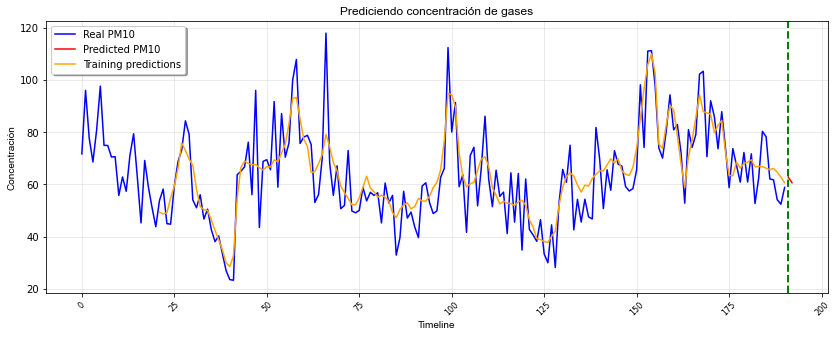

In [44]:
# Graficar las líneas reales, predicciones de entrenamiento y predicciones del futuro
rcParams['figure.figsize'] = 14, 5

plt.plot(dataset_train.loc[0:].index, dataset_train.loc[0:]['PM10'], color='b', label='Real PM10')
plt.plot(range(191,191+2), PREDICTIONS_FUTURE['PM10'], color='r', label='Predicted PM10')
plt.plot(range(191-170,191), PREDICTION_TRAIN['PM10'], color='orange', label='Training predictions')

plt.axvline(x = 191, color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Prediciendo concentración de gases', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Concentración', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()